In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model
import scipy.linalg as la
import seaborn as sns
from sklearn.preprocessing import StandardScaler

## Writing Linear regression by least squares function:

In [3]:
def add_constant(X):
    """Adds a feature column of constant(1) for ß0 to feature matrix X."""
    constant_vector = np.ones((X.shape[0], 1))
    X = np.hstack((constant_vector, X))
    return X   

In [4]:
def multilinear_regression_fit(X_train, y_train):
    """Fits linear regression model on training data. Minimizes gradient of cost function using closed form approach."""
    X = add_constant(X_train)
    A = X.T @ X
    b = (X.T).dot(y_train)
                                                        #Solve Aß = b using cholesky factorization for ß
    c, low = la.cho_factor(A)
    ß = la.cho_solve((c, low), b)
    return ß

def multilinear_regression_predict(ß, X):
    """Predicts output for X feature matrix using fitted LR parameters ß."""
    X = add_constant(X)
    return np.dot(X, ß)

def multilinear_regression(X_train, y_train, X_predict):
    """Performs linear regression.
    Args:
        X_train: feature matrix for training the model.
        y_train: array of training output.
        X_predict: feature matrix for prediction.
    Returns:
        predictions: array of predicted outputs.
    """
    weights = multilinear_regression_fit(X_train, y_train)
    predictions = multilinear_regression_predict(weights, X_predict)
    return predictions

## Part a) Example 4.3

Load data and perform regression:

In [18]:
X_train = np.array([[0, 0], [1,2], [2,4], [3,0], [4,1]])
y_train = np.array([0, 0.3, 0.75, 1, 2])

X_predict = np.array([[-1, -1, 5, 5], [-1, 5, -1, 5]]).T

y_predict = multilinear_regression(X_train, y_train, X_train)
y_predict

array([-0.12125,  0.33625,  0.79375,  1.28875,  1.7525 ])

Plot result:

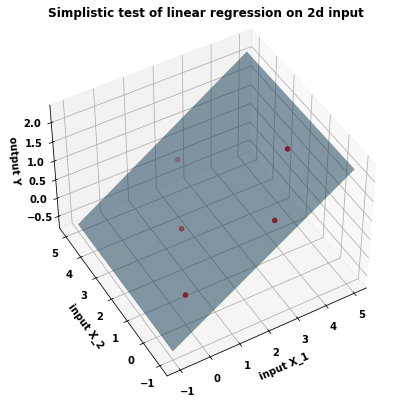

In [6]:
fig = plt.figure(figsize=(6, 5))
ax = Axes3D(fig, elev=45, azim=-120)
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, c='r', marker='o', label='training set')
ax.plot_surface(np.array([[-1, -1], [5, 5]]), np.array([[-1, 5], [-1, 5]]), y_predict.reshape((2, 2)), alpha=.5, label='linear regression predictor')
ax.set_xlabel('input X_1')
ax.set_ylabel('input X_2')
ax.set_zlabel('output Y')
plt.title("Simplistic test of linear regression on 2d input")
plt.show()

## Part b) Energy Efficiency dataset

Load data:

In [7]:
energy = pd.read_excel('ENB2012_data.xlsx', engine='openpyxl')
energy.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2,Unnamed: 10,Unnamed: 11
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33,NaN,NaN
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33,NaN,NaN
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33,NaN,NaN
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33,NaN,NaN
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28,NaN,NaN


Linear regression:

In [8]:
X_train_energy = energy.iloc[:,0:8].values
y_train_energy = energy.iloc[:,8].values

X_predict_energy = energy.iloc[:3,0:8].values

y_predict_energy = multilinear_regression(X_train_energy, y_train_energy, X_predict_energy)

y_predict_energy

LinAlgError: 5-th leading minor of the array is not positive definite

Hmm..curious. Why are we getting this error?
On further inspection, it seems that we only get this error when we put 0th and 91st row(sample) together for training. Excluding either one of those from training set doesn't give the error and gives the correct result.
Below we see both the trouble causing records and they don't seem like they should be causing a problem.

In [9]:
energy.iloc[[0,91],:]

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2,Unnamed: 10,Unnamed: 11
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33,NaN,NaN
91,0.64,784.0,343.0,220.50,3.5,5,0.1,1,15.21,19.32,NaN,NaN


The error says something related to A (X.T @ X - covariance matrix) not being positive definite. We know that the covariance matrix in theory, should be positive semi-definite and positive definite if X is full rank (which must be true if number of rows >> number of columns).
In theory we should not get this error, but in practice there can be floating point errors. If you look at the covariance matrix, some values are very large and some are very very small. This is because some features of X(e.g. X3, X4) are much larger than some others (e.g. X1).
Let's try standardizing(0 mean and 1 variance) the data in hopes of getting rid of any numerical errors.

In [10]:
# create a scaler object
std_scaler = StandardScaler()
energy_standardized = pd.DataFrame(std_scaler.fit_transform(energy.iloc[:,:8]), columns=energy.columns[:8])
energy_standardized.head()

,X1,X2,X3,X4,X5,X6,X7,X8
0,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.341641,-1.760447,-1.814575
1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-0.447214,-1.760447,-1.814575
2,2.041777,-1.785875,-0.561951,-1.470077,1.0,0.447214,-1.760447,-1.814575
3,2.041777,-1.785875,-0.561951,-1.470077,1.0,1.341641,-1.760447,-1.814575
4,1.284979,-1.229239,0.000000,-1.198678,1.0,-1.341641,-1.760447,-1.814575


Try performing linear regression on standadized data:

In [11]:
X_train_energy_standardized = energy_standardized.iloc[:,0:8].values
y_train_energy = energy.iloc[:,8].values

X_predict_energy_standardized = energy_standardized.iloc[:3,0:8].values

y_predict_energy = multilinear_regression(X_train_energy_standardized, y_train_energy, X_predict_energy_standardized)

y_predict_energy

array([22.64717857, 22.62384836, 22.60051815])

Check your result using sklearn library (feeeding non standardized data):

In [12]:
model = linear_model.LinearRegression()
model.fit(X_train_energy, y_train_energy)
model.predict(X_predict_energy)

array([22.64409175, 22.62077585, 22.59745996])

The two results are almost equal.

## Part c) Example 4.5

Load training data:

In [13]:
X = np.array([[0], [1], [2], [3], [4]])
y = np.array([0, 0.3, 0.75, 1, 2])

Add random normally ditributed noise to training data(y):

In [14]:
def add_noise(y_train, sigma):
    e = np.random.normal(0, sigma, len(y_train))
    y_train = y_train + e
    return y_train

Plot Linear Regression on noisy data:

In [15]:
def plot_lr_with_noise(sigma):

    X_eval = np.linspace(0,4,1000)
    X_eval = X_eval.reshape(-1,1)

    plt.figure()
    plt.plot(X_eval,multilinear_regression(X, y, X_eval), color='k')
    for i in range(10):
        plt.plot(X_eval, multilinear_regression(X, add_noise(y,sigma), X_eval), alpha=0.3, color='b')
    plt.plot(X,y, 'rs', markersize=12, label="training set")
    plt.title("Linear regression with random noise, sigma=%.2f"%sigma)
    plt.legend()
    plt.show()

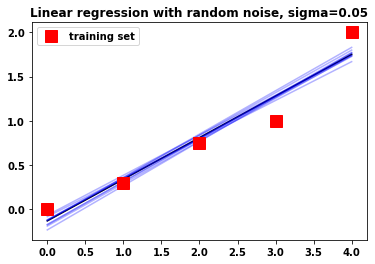

In [16]:
plot_lr_with_noise(0.05)

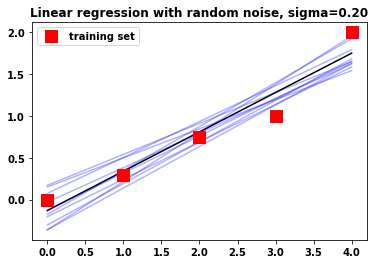

In [17]:
plot_lr_with_noise(0.2)